In [2]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import *
import openmc

# POINT 1 - CHOOSE THE SALT

In [3]:
# EXTRACT ALL THE DATA FOR POINT 1

path="output/1_choose_salts"
salt_directories = ["1_NaF", "2_FLiBe_nat", "3_FLiBe_enr1", "4_FLiBe_enr2"]

hh = np.array([0.2, 0.1, 0.05])*1.65

results = []

for salt_dir in salt_directories:
    salt_list = []
    k_ref = np.genfromtxt("{}/{}/k_ref.csv".format(path, salt_dir), delimiter=',')
    k_ref = ufloat(k_ref[0], k_ref[1])
    salt_list.append(k_ref)
    for h in hh:
        k_p = np.genfromtxt("{}/{}/mod_rho_+{:.2f}.csv".format(path, salt_dir, h), delimiter=',')
        k_p = ufloat(k_p[0], k_p[1])
        k_m = np.genfromtxt("{}/{}/mod_rho_-{:.2f}.csv".format(path, salt_dir, h), delimiter=',')
        k_m = ufloat(k_m[0], k_m[1])
        salt_list.append([k_p, k_m])
    results.append(salt_list)


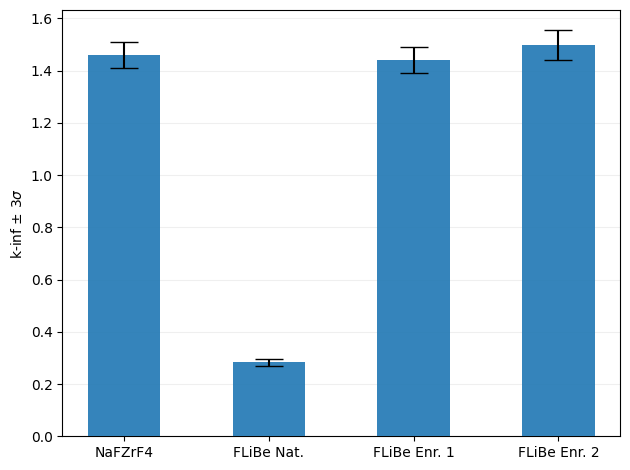

In [4]:
k_refs = [i[0].n for i in results]
k_refs_std = np.array([i[0].std_dev for i in results])

salt_names = ["NaFZrF4", "FLiBe Nat.", "FLiBe Enr. 1", "FLiBe Enr. 2"]

# Build the plot
fig, ax = plt.subplots()
ax.bar(salt_names, k_refs, yerr=3*k_refs_std, width=0.5, align='center', alpha=0.9, ecolor='black', capsize=10, zorder=3)
ax.set_ylabel("k-inf $\pm$ $3\sigma$")
ax.yaxis.grid(True, alpha=.2, zorder=0)

# Save the figure and show
plt.tight_layout()
plt.savefig('images/point_1/k_refs_salts.png', dpi=800)
plt.show()

In [5]:
def central_difference(kk, h):
    k_forw = kk[0]
    k_back = kk[1]
    
    coeff = (1/k_back - 1/k_forw)*1e5/2/h
    return coeff

In [6]:
hh = [20, 10, 5]

mod_coeffs = []

for i in range(len(salt_names)):
    new_salt = []
    for j in range(len(hh)):
        coeff = central_difference(results[i][1+j], hh[j])
        new_salt.append(coeff)
    mod_coeffs.append(new_salt)


In [7]:
# save MDC plots
for i in range(len(salt_names)):
    plt.errorbar(hh, [c.n for c in mod_coeffs[i]], [c.std_dev for c in mod_coeffs[i]], color='k', capsize=5, marker='o')
    plt.xlabel("Perturbation (%)") 
    plt.ylabel(r"Moderator Density Coefficient $\pm$ $\sigma$ (pcm/%)")
    plt.title(salt_names[i], fontsize=15)
    plt.grid(alpha=.4)
    plt.savefig('images/point_1/MDC {}.png'.format(salt_names[i]), dpi=800)
    plt.clf()

<Figure size 640x480 with 0 Axes>

.

# POINT 2 - NaFZrF4

In [8]:
sp = openmc.StatePoint('output/2_NaF/statepoint_reference.h5', autolink=False)
print(sp.tallies)

t_flux_coolant = sp.get_tally(name='tally_flux_coolant')
df = t_flux_coolant.get_pandas_dataframe()
data = df[['mean', 'std. dev.']]
flux_spectrum_coolant = data.to_numpy()
flux_spectrum_coolant = [ufloat(i[0], i[1]) for i in flux_spectrum_coolant]


t_flux_moderator = sp.get_tally(name='tally_flux_moderator')
df = t_flux_moderator.get_pandas_dataframe()
data = df[['mean', 'std. dev.']]
flux_spectrum_moderator = data.to_numpy()
flux_spectrum_moderator = [ufloat(i[0], i[1]) for i in flux_spectrum_moderator]

t_flux_fuel = sp.get_tally(name='tally_flux_fuel')
df = t_flux_fuel.get_pandas_dataframe()
data = df[['mean', 'std. dev.']]
flux_spectrum_fuel = data.to_numpy()
flux_spectrum_fuel = [ufloat(i[0], i[1]) for i in flux_spectrum_fuel]

{1: Tally
	ID             =	1
	Name           =	tally_flux_coolant
	Filters        =	ParticleFilter, MaterialFilter, EnergyFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength, 2: Tally
	ID             =	2
	Name           =	tally_flux_moderator
	Filters        =	ParticleFilter, MaterialFilter, EnergyFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength, 3: Tally
	ID             =	3
	Name           =	tally_flux_fuel
	Filters        =	ParticleFilter, MaterialFilter, EnergyFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength, 4: Tally
	ID             =	4
	Name           =	tally_fast_fission
	Filters        =	ParticleFilter, EnergyFilter
	Nuclides       =	total
	Scores         =	['fission', 'nu-fission']
	Estimator      =	tracklength, 5: Tally
	ID             =	5
	Name           =	tally_res_escape
	Filters        =	ParticleFilter, EnergyoutFilter, EnergyFilter
	Nuclides       =	total
	Sc

## -) Shannon Entropy

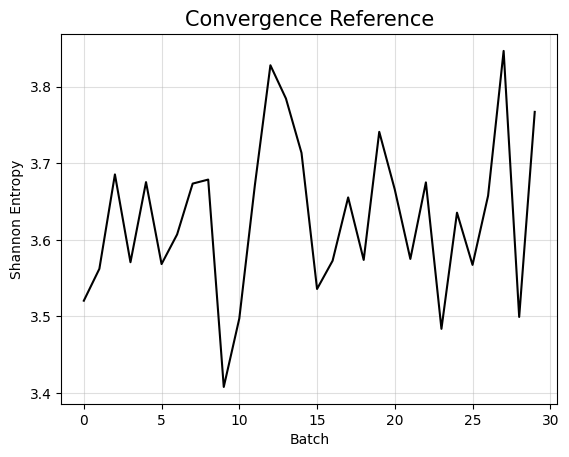

In [15]:
entropy = sp.entropy

plt.plot(entropy, color='k')
plt.xlabel("Batch") 
plt.ylabel("Shannon Entropy")
plt.title("Convergence Reference", fontsize=15)
plt.grid(alpha=.4)

## d) Flux spectrum in different regions

In [156]:
energies = np.logspace(np.log(1e-5), np.log(20e6), base=np.e, num=300)
energies[0] = 0

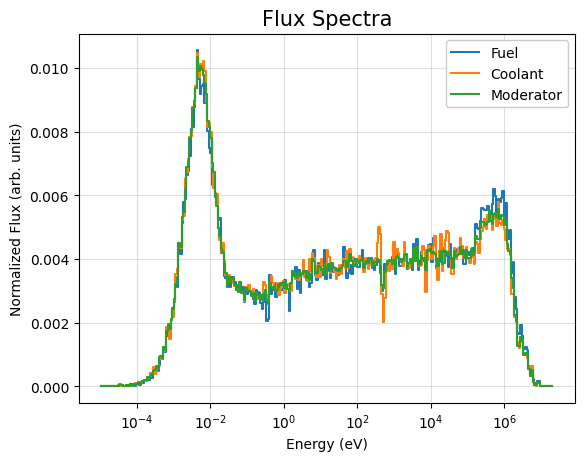

In [157]:
plt.plot(energies[1:], [s.n for s in flux_spectrum_fuel]/np.sum([s.n for s in flux_spectrum_fuel]), drawstyle='steps-pre', label='Fuel')
plt.plot(energies[1:], [s.n for s in flux_spectrum_coolant]/np.sum([s.n for s in flux_spectrum_coolant]), drawstyle='steps-pre', label='Coolant')
plt.plot(energies[1:], [s.n for s in flux_spectrum_moderator]/np.sum([s.n for s in flux_spectrum_moderator]), drawstyle='steps-pre', label='Moderator')
plt.xscale('log')
plt.xlabel("Energy (eV)") 
plt.ylabel("Normalized Flux (arb. units)")
plt.title("Flux Spectra", fontsize=15)
plt.grid(alpha=.4)
plt.legend(framealpha=1)

In [160]:
# NORMALIZATION
pitch = 5.6388/2 #cm
area = 3*np.sqrt(3)*(pitch**2)/2 #cm2
h = 2 #cm
V = area*h / 1000 # L
P = V*20*1000 # W

t_power_normalization = sp.get_tally(name='tally_power_normalization')
df = t_power_normalization.get_pandas_dataframe()
print(df)
df_heating = df.loc[df['score'] == "heating"]
data = df_heating[['mean', 'std. dev.']]
H = data.to_numpy()
H = ufloat(H[0][0], H[0][1]) # eV/src
H = 1.602*(1e-19)*H # J/src

f = P/H # src/s

  nuclide    score     mean  std. dev.
0   total  heating 1.11e+08   2.76e+06
1   total  scatter 1.20e+02   1.08e+00


In [151]:
# PRE PROCESS DATA FOR POINTS e) and f)
t_fast_fission = sp.get_tally(name='tally_fast_fission')
df = t_fast_fission.get_pandas_dataframe()

#neutrons created
df_nu_fission = df.loc[df['score'] == "nu-fission"]
nu_fission = df_nu_fission[['mean', 'std. dev.']].to_numpy()
nu_fission = [ufloat(i[0], i[1]) for i in nu_fission]

# fission
df_fission = df.loc[df['score'] == "fission"]
fission = df_fission[['mean', 'std. dev.']].to_numpy()
fission = [ufloat(i[0], i[1]) for i in fission]


## e) Resonance Escape Probability

In [189]:
t_power_normalization = sp.get_tally(name='tally_power_normalization')
df = t_power_normalization.get_pandas_dataframe()
df_scatter = df.loc[df['score'] == "scatter"]
data = df_scatter[['mean', 'std. dev.']]
total_scatter = data.to_numpy()
total_scatter = ufloat(total_scatter[0][0], total_scatter[0][1]) # react/src


t_res_escape = sp.get_tally(name='tally_res_escape')
df = t_res_escape.get_pandas_dataframe()
data = df[['mean', 'std. dev.']]
scatter_mat = data.to_numpy()
scatter_mat = [ufloat(i[0], i[1]) for i in scatter_mat] # react/src
scatter_ttf = scatter_mat[2] # thermal to fast scattering in react/src
scatter_ftt = scatter_mat[1] # fast to thermal scattering in react/src

# verify that the scatter matrix sums up to the total scattering
print("Total Scattering Integral: {:.2f} react/src".format(total_scatter))
print("Total Scattering Matrix:   {:.2f} react/src".format(np.sum(scatter_mat)))


net_scatter_ftt = scatter_ftt - scatter_ttf # react/src
total_number_fission_neutrons = nu_fission[0] + nu_fission[1] # n/src
res_escape_prob = net_scatter_ftt/total_number_fission_neutrons

print("Resonance Escape Probability: {:.1f} %".format(100*res_escape_prob))

Total Scattering Integral: 120.33+/-1.08 react/src
Total Scattering Matrix:   120.42+/-0.98 react/src
Resonance Escape Probability: 42.7+/-1.6 %


## f) Percentage of Fast Fission

In [162]:
ff = fission[1]/(fission[0]+fission[1])
print("Fast Fission Contribution: {:.2f} %".format(100*ff))

Fast Fission Contribution: 16.97+/-0.46 %


## i) Heat Deposition

In [163]:
# CURRENTLY TALLIED THE MATERIALS

t_heat_fuel = sp.get_tally(name='tally_heat_fuel')
df = t_heat_fuel.get_pandas_dataframe()
data = df[['mean', 'std. dev.']]
heat_fuel = data.to_numpy()
heat_fuel = ufloat(heat_fuel[0][0], heat_fuel[0][1])*1.602*(1e-19)*f # W

t_heat_coolant = sp.get_tally(name='tally_heat_coolant')
df = t_heat_coolant.get_pandas_dataframe()
data = df[['mean', 'std. dev.']]
heat_coolant = data.to_numpy()
heat_coolant = ufloat(heat_coolant[0][0], heat_coolant[0][1])*1.602*(1e-19)*f # W

t_heat_moderator = sp.get_tally(name='tally_heat_moderator')
df = t_heat_moderator.get_pandas_dataframe()
data = df[['mean', 'std. dev.']]
heat_moderator = data.to_numpy()
heat_moderator = ufloat(heat_moderator[0][0], heat_moderator[0][1])*1.602*(1e-19)*f # W

print("Heat in Fuel      :  {:.3f} W   -  {:.2f} %".format(heat_fuel, 100*heat_fuel/(H*f)))
print("Heat in Coolant   :  {:.3f} W      -  {:.2f} %".format(heat_coolant, 100*heat_coolant/(H*f)))
print("Heat in Moderator :  {:.3f} W     -  {:.2f} %".format(heat_moderator, 100*heat_moderator/(H*f)))

Heat in Fuel      :  806.105+/-28.796 W   -  97.58+/-3.49 %
Heat in Coolant   :  0.897+/-0.028 W      -  0.11+/-0.00 %
Heat in Moderator :  18.031+/-0.559 W     -  2.18+/-0.07 %
